## $\color{SkyBlue}{\text{Hypothesis 3}}$
#### $\color{SkyBlue}{\text{Cole Krant}}$

### Description

How does the size of the city affect their likelihood of winning? (larger talent pool)

<br>
<br>

$\rule{27cm}{0.4pt}$ 
### Import Libraries

In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

$\rule{27cm}{0.4pt}$
### K-Means Algorithm

In [3]:
#--------------------------------------------------------------------------------#
def dist(x1, x2):
    return np.sqrt(np.sum(x1-x2)**2)
#--------------------------------------------------------------------------------#

In [127]:
#--------------------------------------------------------------------------------#
def kMeans(df, k=4, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    #---------------------------------------#
    #-- Initialize --#
    clusters = np.zeros(len(df))
    centroids = df.sample(k).values
    mean_error = np.inf
    converged = False
    
    num_iterations = 0
    
    #---------------------------------------#
    #-- LOOP UNTIL CONVERGENCE --#
    while not(converged):

        #-- Cluster Assignment --#
        for index, data in enumerate(df.values):
            distances = [dist(data, centroid) for centroid in centroids]
            clusters[index] = np.argmin(distances)
        
        #-- Update Centroids --#
        updated_centroids = np.empty((k, df.shape[1]))
        for index in range(k):
            clust_data = df[clusters == index]
            centroid = clust_data.mean(axis=0)
            updated_centroids[index, :] = centroid
            
        #-- Calculate Meanerror --#
        errors = []



        print(df.values)
        print(clusters)




        for data, cluster in zip(df.values, clusters):
            centroid = updated_centroids[int(cluster)]
            errors.append(dist(data, centroid)**2)
        
        error_arr = np.array(errors)
        
        #-- Calculate Reconstruction Error --#
        rec_err = np.sum(error_arr)/len(df)
        
        #-- Check for Convergence --#
        if (abs(rec_err - mean_error) < tol):
            converged = True
                    
        # Update Values
        centroids = updated_centroids
        mean_error = rec_err
        num_iterations = num_iterations + 1
        
    #---------------------------------------#
    return centroids, clusters, mean_error
#--------------------------------------------------------------------------------#

$\rule{27cm}{0.4pt}$ 
### Dataframe Composition

In [25]:
#--------------------------------------------------------------------------------#
## Population Dataframe
#  Import wage_population.csv
#  Get the columns 'City', 'Zipcode', 'EstimatedPopulation', 'TotalWages'
#  Drop any rows with missing values

df_population = pd.read_csv('data/wages_population.csv')
df_population = df_population[['City', 'Zipcode', 'EstimatedPopulation', 'TotalWages']]
df_population = df_population.dropna()
df_population.head()
#--------------------------------------------------------------------------------#

,City,Zipcode,EstimatedPopulation,TotalWages
112,MONITOR,7093,42640.0,1.071976e+09
113,TAURUS,7093,42640.0,1.071976e+09
114,WESTWOOD,7675,24083.0,1.089095e+09
115,OLD TAPPAN,7675,24083.0,1.089095e+09
116,RIVER VALE,7675,24083.0,1.089095e+09


In [28]:
#--------------------------------------------------------------------------------#
## Population Dataframe
#  Normalize the cities to be lowercase

for i in range(len(df_population)):
    df_population.iloc[i, 0] = df_population.iloc[i, 0].lower()
#--------------------------------------------------------------------------------#

In [30]:
#--------------------------------------------------------------------------------#
df_population.head()
#--------------------------------------------------------------------------------#

,City,Zipcode,EstimatedPopulation,TotalWages
112,monitor,7093,42640.0,1.071976e+09
113,taurus,7093,42640.0,1.071976e+09
114,westwood,7675,24083.0,1.089095e+09
115,old tappan,7675,24083.0,1.089095e+09
116,river vale,7675,24083.0,1.089095e+09


In [6]:
#--------------------------------------------------------------------------------#
## Rankings
#   Abbreviation (id)
#   Rank
#   Year
#   Conference
df_rankings = pd.read_csv("data/rankings.csv")

#-- LOOP: clean the stars from the data --#
for i in range(len(df_rankings)):
    if (df_rankings["Team"].iloc[i].find('*')):
        df_rankings["Team"].iloc[i] = df_rankings["Team"].iloc[i].replace('*', '')

df_rankings = df_rankings[(df_rankings["Year"] == 2018) |
                          (df_rankings["Year"] == 2019) |
                          (df_rankings["Year"] == 2020) |
                          (df_rankings["Year"] == 2021) |
                          (df_rankings["Year"] == 2022) ]

print(df_rankings)
#--------------------------------------------------------------------------------#

                      Team  Rank  Year Converence
30            Phoenix Suns     1  2022       West
31       Memphis Grizzlies     2  2022       West
32   Golden State Warriors     3  2022       West
33        Dallas Mavericks     4  2022       West
34               Utah Jazz     5  2022       West
..                     ...   ...   ...        ...
175        New York Knicks    11  2018       East
176          Brooklyn Nets    12  2018       East
177          Chicago Bulls    13  2018       East
178          Orlando Magic    14  2018       East
179          Atlanta Hawks    15  2018       East

[150 rows x 4 columns]


In [34]:
#--------------------------------------------------------------------------------#
## Get teams dataframe
df_team = pd.read_csv("data/team.csv")
df_team = df_team[["full_name", "city"]]

## Normalize the cities to be lowercase
for i in range(len(df_team)):
    df_team.iloc[i, 1] = df_team.iloc[i, 1].lower()

df_team.head()
#--------------------------------------------------------------------------------#

,full_name,city
0,Atlanta Hawks,atlanta
1,Boston Celtics,boston
2,Cleveland Cavaliers,cleveland
3,New Orleans Pelicans,new orleans
4,Chicago Bulls,chicago


In [84]:
#--------------------------------------------------------------------------------#
## Merege team and rankings dataframes by their team
#    include the year, rank and conference

df_team_rankings = pd.merge(df_team, df_rankings, left_on='full_name', right_on='Team', how='inner')
df_team_rankings = df_team_rankings[['full_name', 'city', 'Year', 'Rank', 'Converence']]

#--------------------------------------------------------------------------------#

In [89]:
#--------------------------------------------------------------------------------#
## Create a dictionary that maps each team to its respective city

dict = {'Team' : [], 'City' : [], 'Zip' : [], 'Year' : [], 'Rank' : [], 'Conference' : [], 'EstimatedPopulation' : [], 'TotalWages' : []}
dfDictionary = pd.DataFrame(dict)

for i in range(len(df_team_rankings)):
    for j in range(len(df_population)):

        ##-- Merge the cities --##
        if (df_team_rankings.iloc[i, 1] == df_population.iloc[j, 0]):
            
            ##-- Get df_team rank data --##
            team = df_team_rankings.iloc[i, 0]
            city = df_team_rankings.iloc[i, 1]
            year = df_team_rankings.iloc[i, 2]
            rank = df_team_rankings.iloc[i, 3]
            conference = df_team_rankings.iloc[i, 4]

            ##-- Get the population and wages --##
            zip = df_population.iloc[j, 1]
            population = df_population.iloc[j, 2]

            ##-- Normalize wages --##
            wages = df_population.iloc[j, 3] / population

            ##-- Append to the master dataframe --##
            temp = {'Team' : team, 'City' : city, 'Zip' : zip, 'Year' : year, 'Rank' : rank, 'Conference' : conference, 
                    'EstimatedPopulation' : population, 'TotalWages' : wages}
            

            df_temp = pd.DataFrame(temp, index=[0])

            dfDictionary = pd.concat([dfDictionary, df_temp], ignore_index = True)                             # append the temporary dataframe to the master dataframe
            dfDictionary = dfDictionary.reset_index(drop=True)


#--------------------------------------------------------------------------------#

In [130]:
#--------------------------------------------------------------------------------#
## in dfDictionary, sum the total wages for each city and estimated population. make sure to seperate by year make sure to keep the team name and rank for a given year
df_sum = dfDictionary.groupby(['Year', 'City']).agg({'TotalWages': 'sum', 'EstimatedPopulation': 'sum', 'Team': 'first', 'Rank': 'first'}).reset_index()

## convert all numerical values to integers
df_sum['TotalWages'] = df_sum['TotalWages'].astype(int)
df_sum['EstimatedPopulation'] = df_sum['EstimatedPopulation'].astype(int)
df_sum['Rank'] = df_sum['Rank'].astype(int)

df_sum.head(100)
#--------------------------------------------------------------------------------#

,Year,City,TotalWages,EstimatedPopulation,Team,Rank
0,2018.0,atlanta,1707601,845573,Atlanta Hawks,15
1,2018.0,boston,1647994,436964,Boston Celtics,2
2,2018.0,brooklyn,991674,1749295,Brooklyn Nets,12
3,2018.0,charlotte,947904,588704,Charlotte Hornets,10
4,2018.0,chicago,1821525,2014855,Chicago Bulls,13
...,...,...,...,...,...,...
95,2021.0,oklahoma city,1277383,478046,Oklahoma City Thunder,13
96,2021.0,orlando,1149813,680908,Orlando Magic,15
97,2021.0,philadelphia,1203070,1044805,Philadelphia 76ers,2
98,2021.0,phoenix,1528345,986868,Phoenix Suns,2


In [131]:
# ## Split into by year
print(dfDictionary["Year"].unique())                   # get all unique years


df_18 = df_sum[df_sum["Year"] == 2018.0]
df_19 = df_sum[df_sum["Year"] == 2019.0]
df_20 = df_sum[df_sum["Year"] == 2020.0]
df_21 = df_sum[df_sum["Year"] == 2021.0]
df_22 = df_sum[df_sum["Year"] == 2022.0]

df_22.head(100)

[2022. 2021. 2020. 2019. 2018.]


,Year,City,TotalWages,EstimatedPopulation,Team,Rank
104,2022.0,atlanta,1707601,845573,Atlanta Hawks,9
105,2022.0,boston,1647994,436964,Boston Celtics,3
106,2022.0,brooklyn,991674,1749295,Brooklyn Nets,7
107,2022.0,charlotte,947904,588704,Charlotte Hornets,10
108,2022.0,chicago,1821525,2014855,Chicago Bulls,6
109,2022.0,cleveland,1470528,1109732,Cleveland Cavaliers,8
110,2022.0,dallas,2034321,1056995,Dallas Mavericks,4
111,2022.0,denver,1589966,1050985,Denver Nuggets,6
112,2022.0,detroit,631851,625624,Detroit Pistons,14
113,2022.0,houston,4139689,2164110,Houston Rockets,15


$\rule{27cm}{0.4pt}$ 
### Begin K-Mean Analysis Population

In [132]:
#--------------------------------------------------------------------------------#
## Use k-Means for clustering
centroids_22, clusters_22, mean_error_22 = kMeans(df_22[["Rank", "EstimatedPopulation"]], k=3)
centroids_21, clusters_21, mean_error_21 = kMeans(df_21[["Rank", "EstimatedPopulation"]], k=3)
centroids_20, clusters_20, mean_error_20 = kMeans(df_20[["Rank", "EstimatedPopulation"]], k=3)
centroids_19, clusters_19, mean_error_19 = kMeans(df_19[["Rank", "EstimatedPopulation"]], k=3)
centroids_18, clusters_18, mean_error_18 = kMeans(df_18[["Rank", "EstimatedPopulation"]], k=3)
#--------------------------------------------------------------------------------#

[[      9  845573]
 [      3  436964]
 [      7 1749295]
 [     10  588704]
 [      6 2014855]
 [      8 1109732]
 [      4 1056995]
 [      6 1050985]
 [     14  625624]
 [     15 2164110]
 [     13   21441]
 [      8 3466584]
 [      2  597844]
 [      1 1818462]
 [      2  605922]
 [      9  246191]
 [     11 1111873]
 [     14  478046]
 [     15  680908]
 [      4 1044805]
 [      1  986868]
 [     13  855155]
 [     12  581864]
 [     10 1201431]
 [      5    9580]
 [     12  635654]]
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2. 1. 0. 2. 1. 0. 1. 1. 0.
 0. 0.]


TypeError: 'numpy.int64' object is not callable

### Plot the resulting graph

TypeError: 'numpy.int64' object is not callable

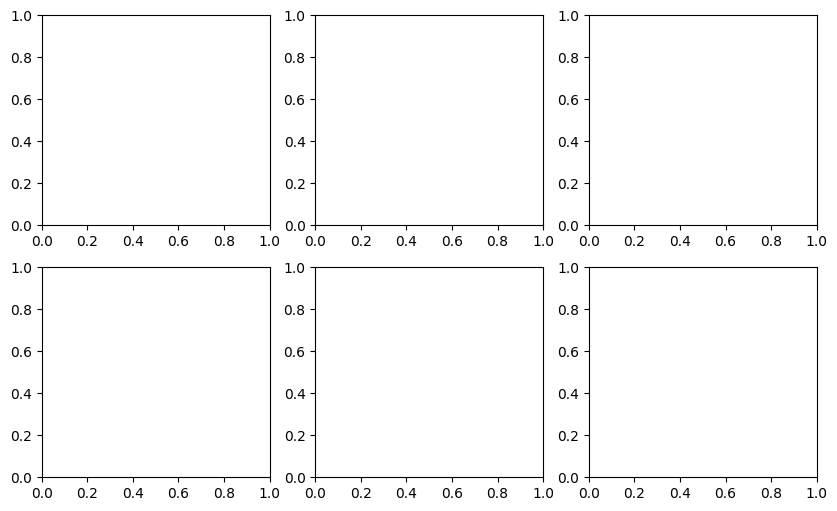

In [111]:
#--------------------------------------------------------------------------------#
import matplotlib.pyplot as plt

## Create lists to use for loop iteration for plotting
#  dataframes, contains all the dataframes for each year
#  clusters, contains all the clusters for each year
#  years, contains all the years

dataframes = [df_18, df_19, df_20, df_21, df_22]
clusters = [clusters_18, clusters_19, clusters_20, clusters_21, clusters_22]
centroids = [centroids_18, centroids_19, centroids_20, centroids_21, centroids_22]
years = [2018, 2019, 2020, 2021, 2022]

## Initialize Plot
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

## LOOP : Scatter Plot for each Year
for i, (year, dataframe) in enumerate(zip(years, dataframes)):
    ax = axes[i]
    ax.scatter(dataframe['Rank'], dataframe['EstimatedPopulation'], c=clusters[i], marker='*', s=200)
    ax.set_xlim(-1, 16)
    ax.set_xlabel("Rank")
    ax.set_ylabel("City Population")
    ax.set_title("Scatter Plot for Year " + str(year))

    #-- Plot Centroids --#
    c = centroids[i]
    ax.scatter(c[:, 0], c[:, 1], marker='X', c='black', s=200, label='Centroids')

plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------#

$\rule{27cm}{0.4pt}$ 
### k-Mean Analysis Wages

In [112]:
#--------------------------------------------------------------------------------#
centroids_22, clusters_22, mean_error_22 = kMeans(df_22[["Rank", "TotalWages"]], k=3)
centroids_21, clusters_21, mean_error_21 = kMeans(df_21[["Rank", "TotalWages"]], k=3)
centroids_20, clusters_20, mean_error_20 = kMeans(df_20[["Rank", "TotalWages"]], k=3)
centroids_19, clusters_19, mean_error_19 = kMeans(df_19[["Rank", "TotalWages"]], k=3)
centroids_18, clusters_18, mean_error_18 = kMeans(df_18[["Rank", "TotalWages"]], k=3)
#--------------------------------------------------------------------------------#

TypeError: 'numpy.int64' object is not callable

### Plot the resulting Graph

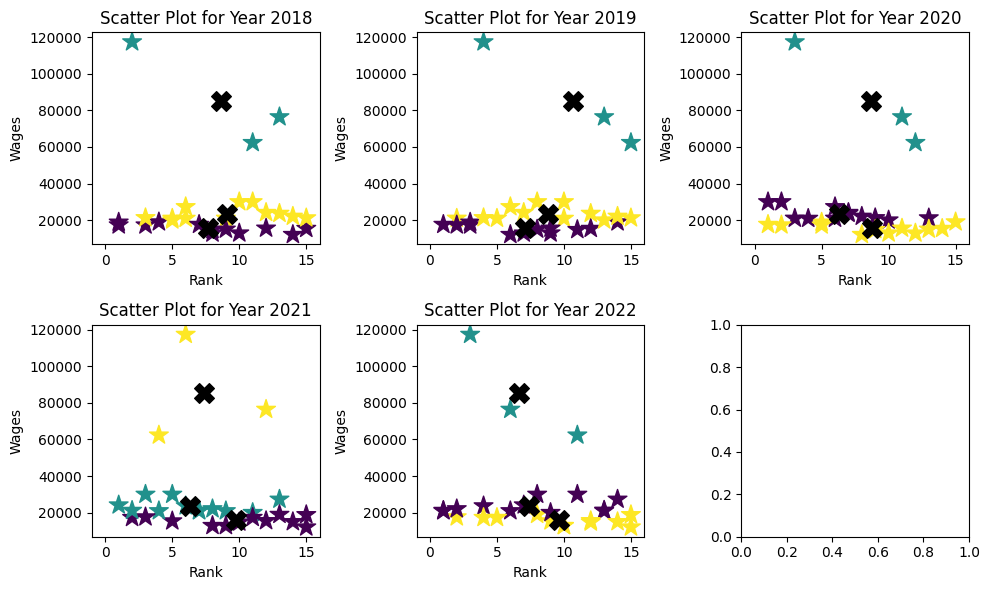

In [74]:
#--------------------------------------------------------------------------------#
import matplotlib.pyplot as plt

## Create lists to use for loop iteration for plotting
#  dataframes, contains all the dataframes for each year
#  clusters, contains all the clusters for each year
#  years, contains all the years

dataframes = [df_18, df_19, df_20, df_21, df_22]
clusters = [clusters_18, clusters_19, clusters_20, clusters_21, clusters_22]
centroids = [centroids_18, centroids_19, centroids_20, centroids_21, centroids_22]
years = [2018, 2019, 2020, 2021, 2022]

## Initialize Plot
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

## LOOP : Scatter Plot for each Year
for i, (year, dataframe) in enumerate(zip(years, dataframes)):
    ax = axes[i]
    ax.scatter(dataframe['Rank'], dataframe['TotalWages'], c=clusters[i], marker='*', s=200)
    ax.set_xlim(-1, 16)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Wages")
    ax.set_title("Scatter Plot for Year " + str(year))

    #-- Plot Centroids --#
    c = centroids[i]
    ax.scatter(c[:, 0], c[:, 1], marker='X', c='black', s=200, label='Centroids')

plt.tight_layout()
plt.show()
#--------------------------------------------------------------------------------#

In [77]:
#--------------------------------------------------------------------------------#
## use df_18 to get the highest wage city
df_18[df_18['TotalWages'] == df_18['TotalWages'].max()]
df_19[df_19['TotalWages'] == df_19['TotalWages'].max()]
df_20[df_20['TotalWages'] == df_20['TotalWages'].max()]


#--------------------------------------------------------------------------------#

,Team,City,Year,Rank,Conference,EstimatedPopulation,TotalWages
435,Boston Celtics,boston,2019.0,4.0,East,3312.0,117386.314614


$\rule{27cm}{0.4pt}$ 
### Analysis



### Improvement

Since it appears the average height and weight doesn't appear to be a strong indication of their final rank in the NBA, perhaps we can take the maximum height 